# HOMEWORK 4- ML EVALUATION
## Using the lead scoring dataset Bank Marketing

## Set up environment

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression


%matplotlib inline

## Dataset

In this homework, we will use the lead scoring dataset Bank Marketing dataset.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In this dataset our desired target for classification task will be *converted* variable - has the client signed up to the platform or not.

## Data preparation

Check if the missing values are presented in the features.
If there are missing values:
For caterogiral features, replace them with 'NA'
For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use *train_test_split* function for that with *random_state=1*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [5]:
# check if there are missing values in the df
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
# Replacing missing values

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('NA')
    elif np.issubdtype(df[col].dtype, np.number):
        df[col] = df[col].fillna(0)
    else: print('Type unexpected')

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
# Splitting the data

from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that
  
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* `lead_score`
* `number_of_courses_viewed`
* `interaction_count`
* `annual_income`

In [10]:
df_numeric = df.select_dtypes(include='number')
del df_numeric['converted']
numerical= df_numeric.columns.values

In [11]:
for n in numerical:
    auc_score = roc_auc_score(y_train, df_train[n])
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[n])
    print(f"{n} has AUC of {auc_score:.3f}")

number_of_courses_viewed has AUC of 0.764
annual_income has AUC of 0.552
interaction_count has AUC of 0.738
lead_score has AUC of 0.614


R/ `number_of_courses_viewed` has higuest AUC

## Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.32
* 0.52
* 0.72
* 0.92

In [12]:
df_cat_train = df_train.select_dtypes(include='object')
categorical = df_cat_train.columns
categorical

Index(['lead_source', 'industry', 'employment_status', 'location'], dtype='object')

In [13]:
# Feature Scaling - Preparing the numerical features
X_train_num = df_train[numerical].values

scaler = StandardScaler()
X_train_num =scaler.fit_transform(X_train_num)

In [14]:
# One Hot Encoding - Preparing the categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = ohe.fit_transform(df_train[categorical].values)

In [15]:
ohe.get_feature_names_out()

array(['x0_NA', 'x0_events', 'x0_organic_search', 'x0_paid_ads',
       'x0_referral', 'x0_social_media', 'x1_NA', 'x1_education',
       'x1_finance', 'x1_healthcare', 'x1_manufacturing', 'x1_other',
       'x1_retail', 'x1_technology', 'x2_NA', 'x2_employed',
       'x2_self_employed', 'x2_student', 'x2_unemployed', 'x3_NA',
       'x3_africa', 'x3_asia', 'x3_australia', 'x3_europe',
       'x3_middle_east', 'x3_north_america', 'x3_south_america'],
      dtype=object)

In [16]:
# Combine the two matrices into one
X_train = np.column_stack([X_train_num, X_train_cat])

In [17]:
# Train de model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [18]:
# Now let's check its accuracy
X_val_num = df_val[numerical].values
X_val_num =scaler.transform(X_val_num)

X_val_cat = ohe.transform(df_val[categorical].values)

# Combine the two matrices into one
X_val = np.column_stack([X_val_num, X_val_cat])
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"Validation set AUC: {auc:.3f}")

Validation set AUC: 0.921


## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [58]:
scores = []

thresholds = np.arange(0, 1.01,  0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [60]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [61]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,171,122,0,0,0.583618,1.000000
1,0.01,171,116,0,6,0.595819,1.000000
2,0.02,171,110,0,12,0.608541,1.000000
3,0.03,170,108,1,14,0.611511,0.994152
4,0.04,170,103,1,19,0.622711,0.994152
...,...,...,...,...,...,...,...
96,0.96,66,1,105,121,0.985075,0.385965
97,0.97,61,0,110,122,1.000000,0.356725
98,0.98,51,0,120,122,1.000000,0.298246
99,0.99,39,0,132,122,1.000000,0.228070


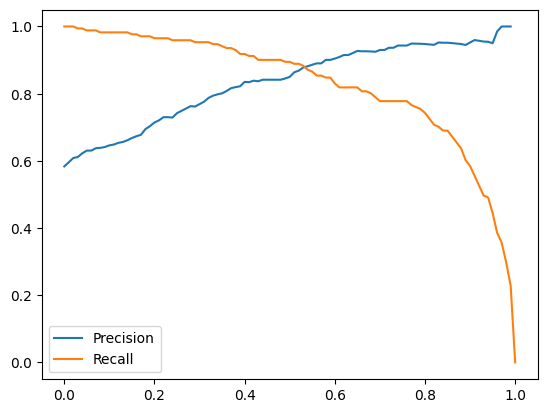

In [62]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [72]:
diff = np.abs(df_scores['precision'] - df_scores['recall'])
idx = diff.idxmin() 

threshold_intersect = df_scores.loc[idx, 'threshold']
print(f"Precision and recall intersect approximately at threshold {threshold_intersect:.2f}")

Precision and recall intersect approximately at threshold 0.53


## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2.(P.R)/(P+R)

Where _P_ is precision and _R_ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.14
* 0.34
* 0.54
* 0.74

## Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation
* 
How large is standard deviation of the scores across different folds?

* 0.0001
* 0.006
* 0.06
* 0.36

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
  
Which `C` leads to the best mean score?

*0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.